## Recurrent Neural Network

### Name: Shane Bowen

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM
from matplotlib import pyplot

## Series to Supervised Function

In [2]:
# convert series to supervised learning & normalize input variables
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Load Dataset

In [3]:
# load dataset
df = pd.read_csv('../reports/company_report_sorted.csv', header=0)

In [4]:
df.describe()

,company_id,date,month,year,is_weekend,avg_pesq_score,quality_too_poor,number_busy,temporarily_unable_test,outage_hrs,number_test_types,numbers_tested,followup_tests,min_commit,has_min_commit,volume_tests
count,80172.000000,80172.00000,80172.000000,80172.000000,80172.000000,80172.000000,80172.000000,80172.000000,80172.000000,80172.000000,80172.000000,80172.000000,80172.000000,38278.000000,80172.00000,80172.000000
mean,115.270843,15.64283,5.961308,2019.007634,0.285948,1.561956,1.010739,12.334431,1.193023,631.839060,0.829354,62.318889,2.691675,17201.604185,0.47670,688.438233
std,79.333169,8.78044,3.415485,0.750907,0.451867,1.886573,8.951419,67.955426,17.460154,1902.007178,1.035513,308.479887,26.638311,61817.727161,0.49946,4168.578479
min,1.000000,1.00000,1.000000,2018.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,53.000000,8.00000,3.000000,2018.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,583.000000,0.00000,0.000000
50%,103.000000,16.00000,5.000000,2019.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,1.000000,1.000000,0.000000,2000.000000,0.00000,12.000000
75%,173.000000,23.00000,9.000000,2020.000000,1.000000,3.791667,0.000000,2.000000,0.000000,216.000000,1.000000,26.000000,0.000000,7200.000000,1.00000,159.000000
max,364.000000,31.00000,12.000000,2020.000000,1.000000,4.500000,627.000000,4492.000000,1258.000000,13277.440000,6.000000,4267.000000,2337.000000,400000.000000,1.00000,57105.000000


## Data Cleaning

In [5]:
# Find the number of missing data in the dataset
df.apply(lambda x: sum(x.isnull()), axis=0)

company_name                   0
company_id                     0
company_type                   0
time                           0
date                           0
month                          0
year                           0
day                            0
is_weekend                     0
season                         0
avg_pesq_score                 0
quality_too_poor               0
number_busy                    0
temporarily_unable_test        0
outage_hrs                     0
number_test_types              0
numbers_tested                 0
followup_tests                 0
min_commit                 41894
has_min_commit                 0
volume_tests                   0
dtype: int64

In [6]:
df[df['min_commit'].isnull() ]

,company_name,company_id,company_type,time,date,month,year,day,is_weekend,season,...,quality_too_poor,number_busy,temporarily_unable_test,outage_hrs,number_test_types,numbers_tested,followup_tests,min_commit,has_min_commit,volume_tests
4,Marchex,10,Enterprise,2018-01-01,1,1,2018,Mon,0,Winter,...,0,0,0,0.0,1,13,0,NaN,0,672
6,Airbnb,17,Enterprise,2018-01-01,1,1,2018,Mon,0,Winter,...,3,0,0,0.0,1,37,0,NaN,0,1792
12,Mastercard,49,Enterprise,2018-01-01,1,1,2018,Mon,0,Winter,...,0,0,0,24.0,1,10,0,NaN,0,82
18,Tata Communications,75,Enterprise,2018-01-01,1,1,2018,Mon,0,Winter,...,0,0,0,0.0,0,0,0,NaN,0,15
21,Amazon Chime,100,Enterprise,2018-01-01,1,1,2018,Mon,0,Winter,...,2,5,0,24.0,1,68,0,NaN,0,340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80159,NiceInContact,215,Enterprise,2020-06-20,20,6,2020,Sat,1,Summer,...,0,0,0,24.0,0,0,0,NaN,0,8
80164,Johnson & Johnson,245,Enterprise,2020-06-20,20,6,2020,Sat,1,Summer,...,0,0,1,0.0,1,72,0,NaN,0,143
80167,Cisco,255,Enterprise,2020-06-20,20,6,2020,Sat,1,Summer,...,0,2,0,168.0,2,40,3,NaN,0,265
80170,Sykes,285,Enterprise,2020-06-20,20,6,2020,Sat,1,Summer,...,0,0,0,0.0,0,0,0,NaN,0,0


In [7]:
# fill nan with 0
df['min_commit'] = df['min_commit'].fillna(0)
df['min_commit'].count()

80172

## Distribution Analysis

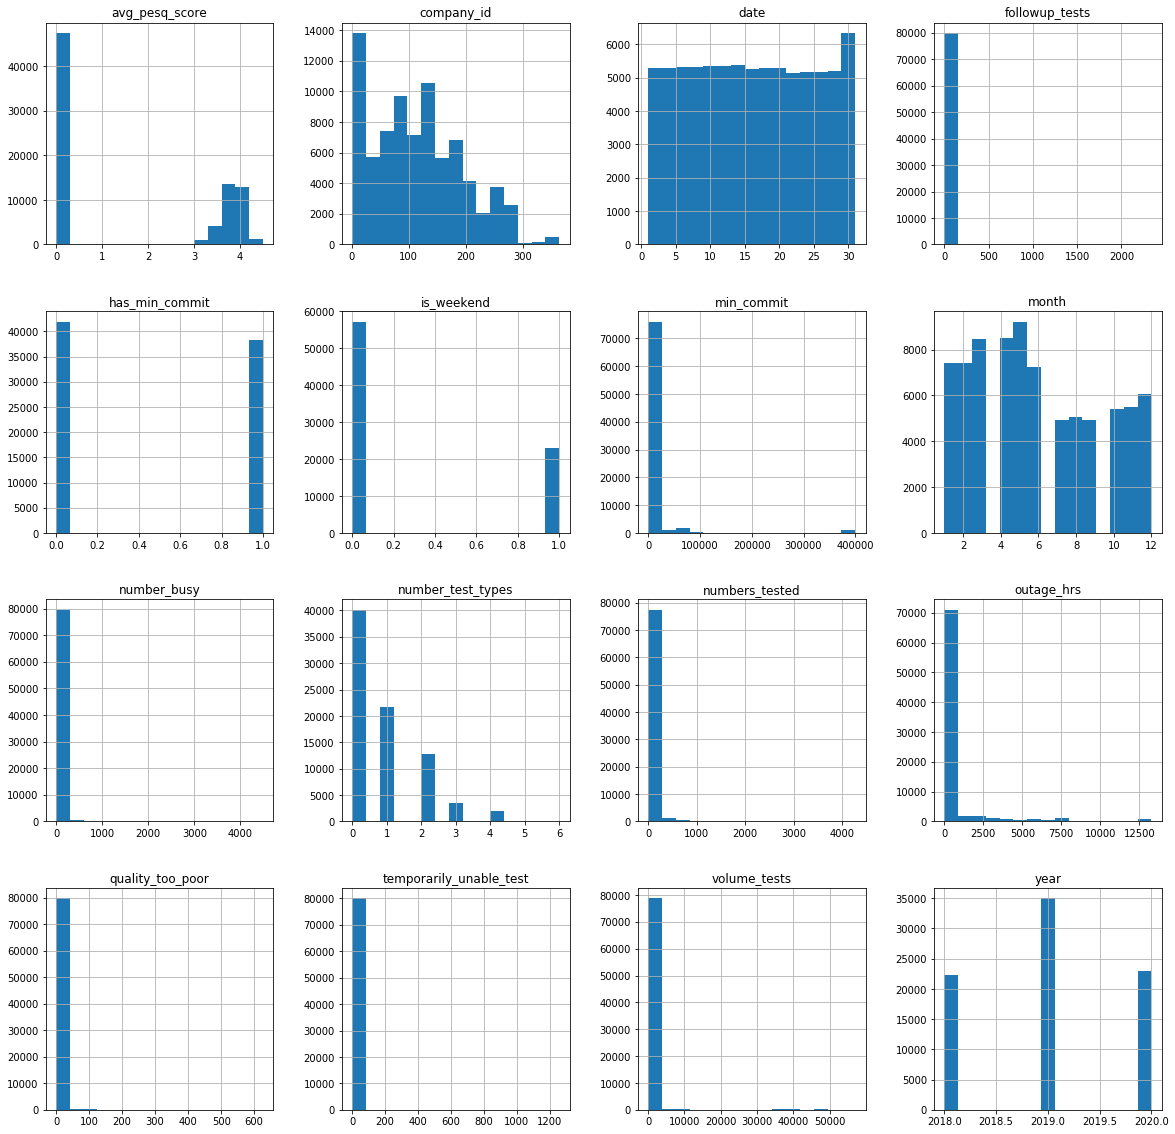

In [8]:
df.hist(bins=15, figsize=(20, 20));

## Handling Outliers

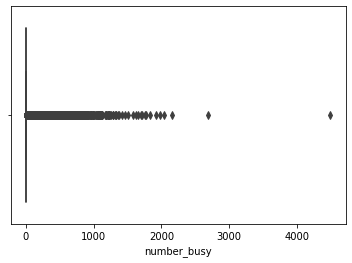

In [9]:
# plot number_busy outliers
sns.boxplot(x=df["number_busy"])

In [10]:
# count number of outliers
print((df[['number_busy']] > 2600).sum())
df[df['number_busy'] > 2600]

number_busy    2
dtype: int64


,company_name,company_id,company_type,time,date,month,year,day,is_weekend,season,...,quality_too_poor,number_busy,temporarily_unable_test,outage_hrs,number_test_types,numbers_tested,followup_tests,min_commit,has_min_commit,volume_tests
27749,Google,2,Enterprise,2019-03-08,8,3,2019,Fri,0,Spring,...,34,4492,0,6478.70,3,3003,2337,400000.0,1,42615
48926,Tata Communications,75,Enterprise,2019-10-19,19,10,2019,Sat,1,Autumn,...,2,2680,0,2159.97,2,110,0,27272.0,1,5164


In [11]:
# remove outliers for number_busy
df = df[df['number_busy'] < 2600]

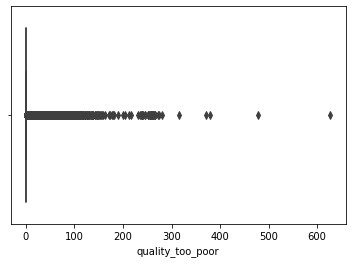

In [12]:
# plot quality_too_poor outliers
sns.boxplot(x=df["quality_too_poor"])

In [13]:
# count number of outliers
print((df[['quality_too_poor']] > 450).sum())
df[df['quality_too_poor'] > 450]

quality_too_poor    2
dtype: int64


,company_name,company_id,company_type,time,date,month,year,day,is_weekend,season,...,quality_too_poor,number_busy,temporarily_unable_test,outage_hrs,number_test_types,numbers_tested,followup_tests,min_commit,has_min_commit,volume_tests
9282,Google,2,Enterprise,2018-06-27,27,6,2018,Wed,0,Summer,...,627,469,68,4353.67,3,2718,130,400000.0,1,40609
48585,Intrado,9,Conference,2019-10-16,16,10,2019,Wed,0,Autumn,...,479,33,11,2232.03,3,133,24,0.0,0,7907


In [14]:
# remove outliers for quality_too_poor
df = df[df['quality_too_poor'] < 450]

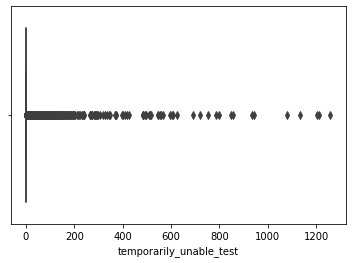

In [15]:
# plot outliers temporarily_unable_test
sns.boxplot(x=df["temporarily_unable_test"])

In [16]:
# count number of outliers
print((df[['temporarily_unable_test']] > 1000).sum())
df[df['temporarily_unable_test'] > 1000]

temporarily_unable_test    5
dtype: int64


,company_name,company_id,company_type,time,date,month,year,day,is_weekend,season,...,quality_too_poor,number_busy,temporarily_unable_test,outage_hrs,number_test_types,numbers_tested,followup_tests,min_commit,has_min_commit,volume_tests
6430,Google,2,Enterprise,2018-05-11,11,5,2018,Fri,0,Summer,...,7,288,1079,3815.03,3,2457,90,400000.0,1,40026
7138,Google,2,Enterprise,2018-05-23,23,5,2018,Wed,0,Summer,...,17,216,1132,3765.83,3,2541,90,400000.0,1,40182
7870,Google,2,Enterprise,2018-06-04,4,6,2018,Mon,0,Summer,...,6,623,1202,4080.27,3,2500,280,400000.0,1,40047
15839,Google,2,Enterprise,2018-10-05,5,10,2018,Fri,0,Autumn,...,38,519,1258,5141.55,3,2669,350,400000.0,1,44042
25858,Google,2,Enterprise,2019-02-14,14,2,2019,Thurs,0,Spring,...,30,414,1213,5927.93,3,3038,153,400000.0,1,46280


In [17]:
# remove outliers for temporarily_unable_test
df = df[df['temporarily_unable_test'] < 1000]

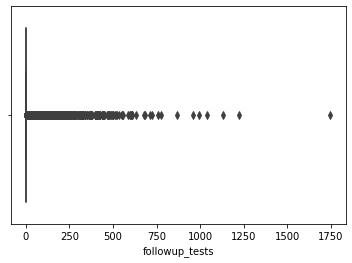

In [18]:
# plot outliers for followup_tests
sns.boxplot(x=df["followup_tests"])

In [19]:
# count number of outliers
print((df[['followup_tests']] > 1200).sum())
df[df['followup_tests'] > 1200]

followup_tests    2
dtype: int64


,company_name,company_id,company_type,time,date,month,year,day,is_weekend,season,...,quality_too_poor,number_busy,temporarily_unable_test,outage_hrs,number_test_types,numbers_tested,followup_tests,min_commit,has_min_commit,volume_tests
16529,Google,2,Enterprise,2018-10-15,15,10,2018,Mon,0,Autumn,...,2,2155,28,5581.40,3,2862,1747,400000.0,1,45696
23910,Google,2,Enterprise,2019-01-21,21,1,2019,Mon,0,Winter,...,14,1621,0,6110.11,3,3016,1224,400000.0,1,47779


In [20]:
# remove outliers for followup_tests
df = df[df['followup_tests'] < 1200]

## Feature Selection

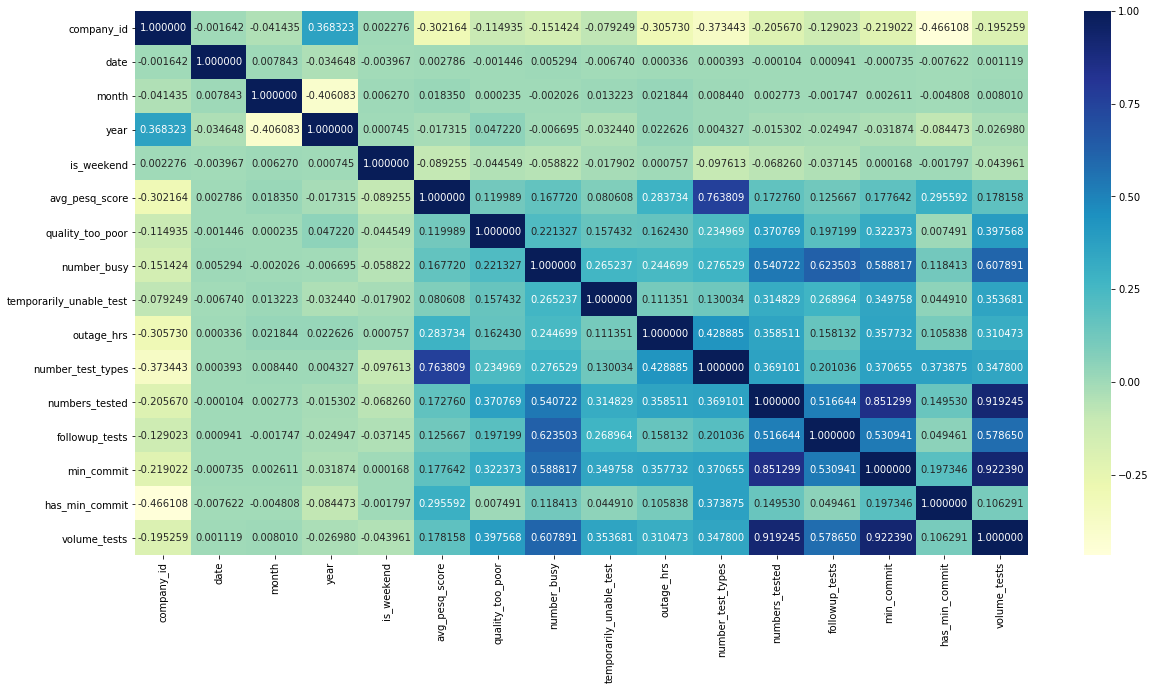

In [21]:
plt.figure(figsize=(20,10))
df_corr= df.corr()
sns.heatmap(df_corr, annot=True, fmt="f", cmap="YlGnBu")

In [22]:
# limit data to first 20 companies (reduce training time)
df_subset = df[(df['company_id'] < 10)]
df_subset

,company_name,company_id,company_type,time,date,month,year,day,is_weekend,season,...,quality_too_poor,number_busy,temporarily_unable_test,outage_hrs,number_test_types,numbers_tested,followup_tests,min_commit,has_min_commit,volume_tests
0,PGI,1,Conference,2018-01-01,1,1,2018,Mon,0,Winter,...,1,86,0,6680.24,2,2562,0,100000.0,1,4590
1,Google,2,Enterprise,2018-01-01,1,1,2018,Mon,0,Winter,...,4,246,0,2208.22,2,2410,100,400000.0,1,35405
2,GoDaddy,4,Enterprise,2018-01-01,1,1,2018,Mon,0,Winter,...,0,1,0,0.00,1,207,0,1500.0,1,302
3,Arkadin,6,Conference,2018-01-01,1,1,2018,Mon,0,Winter,...,0,0,0,695.99,2,62,0,5715.0,1,167
26,PGI,1,Conference,2018-01-02,2,1,2018,Tues,0,Winter,...,2,24,0,6595.96,2,1142,0,100000.0,1,3343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80089,Google,2,Enterprise,2020-06-20,20,6,2020,Sat,1,Summer,...,241,70,0,575.99,6,513,9,400000.0,1,22449
80090,Twilio,3,Carrier,2020-06-20,20,6,2020,Sat,1,Summer,...,0,0,0,0.00,2,15,0,10000.0,1,360
80091,GoDaddy,4,Enterprise,2020-06-20,20,6,2020,Sat,1,Summer,...,0,0,3,72.00,1,290,0,10000.0,1,385
80092,Arkadin,6,Conference,2020-06-20,20,6,2020,Sat,1,Summer,...,2,5,6,168.00,3,153,0,5715.0,1,277


In [23]:
# select features columns
#df_subset = df_subset[['volume_tests', 'date', 'month', 'is_weekend', 'quality_too_poor', 'number_busy', 'temporarily_unable_test', 'outage_hrs', 'number_test_types', 'numbers_tested', 'min_commit', 'has_min_commit']]
df_subset = df_subset[['volume_tests', 'company_id', 'time', 'date', 'month', 'is_weekend', 'quality_too_poor', 'number_busy', 'temporarily_unable_test', 'outage_hrs', 'number_test_types', 'numbers_tested', 'min_commit', 'has_min_commit']]

In [24]:
# get datframe values
values = df_subset.values

In [25]:
# specify the number of days and features 
n_input = 7
n_features = df_subset.shape[1]
n_predict = 7

In [26]:
# integer encode direction
encoder = LabelEncoder()
df_subset.loc[:, ('time')] = encoder.fit_transform(df_subset.loc[:, ('time')])

/home/shanebowen/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [27]:
# # normalize features
# norm_cols = ['volume_tests', 'date', 'month', 'quality_too_poor', 'number_busy', 'temporarily_unable_test', 'outage_hrs', 'number_test_types', 'numbers_tested', 'min_commit']
# scaler = MinMaxScaler(feature_range=(0, 1))
# df_subset.loc[:, (norm_cols)] = scaler.fit_transform(df_subset.loc[:, (norm_cols)])

In [28]:
ids = [2, 9]
reframed = pd.DataFrame()

for id in ids:
    values = df_subset[df_subset['company_id'] == id].values
    reframed = pd.concat([reframed, series_to_supervised(values, n_input, n_predict)])
reframed

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var10(t-7),...,var5(t+6),var6(t+6),var7(t+6),var8(t+6),var9(t+6),var10(t+6),var11(t+6),var12(t+6),var13(t+6),var14(t+6)
7,35405.0,2.0,0.0,1.0,1.0,0.0,4.0,246.0,0.0,2208.22,...,1.0,1.0,4.0,61.0,0.0,2327.97,2.0,275.0,400000.0,1.0
8,36978.0,2.0,1.0,2.0,1.0,0.0,8.0,952.0,0.0,2225.04,...,1.0,0.0,37.0,572.0,0.0,2304.81,2.0,2427.0,400000.0,1.0
9,36978.0,2.0,2.0,3.0,1.0,0.0,22.0,791.0,0.0,2230.62,...,1.0,0.0,59.0,519.0,0.0,2280.16,2.0,2430.0,400000.0,1.0
10,35899.0,2.0,3.0,4.0,1.0,0.0,27.0,824.0,0.0,2209.19,...,1.0,0.0,41.0,455.0,33.0,2280.12,2.0,2423.0,400000.0,1.0
11,34504.0,2.0,4.0,5.0,1.0,0.0,16.0,637.0,0.0,2232.59,...,1.0,0.0,49.0,578.0,0.0,2280.69,2.0,2432.0,400000.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,4829.0,9.0,884.0,3.0,6.0,0.0,4.0,20.0,0.0,2471.97,...,6.0,0.0,0.0,17.0,4.0,120.00,3.0,113.0,0.0,0.0
888,4844.0,9.0,885.0,4.0,6.0,0.0,7.0,4.0,0.0,2471.97,...,6.0,0.0,3.0,4.0,0.0,120.68,3.0,113.0,0.0,0.0
889,4800.0,9.0,886.0,5.0,6.0,0.0,1.0,36.0,0.0,2471.97,...,6.0,0.0,0.0,4.0,8.0,120.00,3.0,113.0,0.0,0.0
890,1.0,9.0,887.0,6.0,6.0,1.0,0.0,0.0,0.0,2471.97,...,6.0,0.0,3.0,31.0,0.0,147.42,3.0,144.0,0.0,0.0


In [29]:
values = reframed.values
values = values[np.lexsort((values[:, 1], values[:, 2]))]

In [104]:
values.shape

(1765, 196)

In [30]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)

In [31]:
# # split into train and test sets
train_size = int(len(values) * 0.8)
test_size = len(values) - train_size
train, test = values[:train_size], values[-test_size:]
print(train.shape, test.shape)

(1412, 196) (353, 196)


In [32]:
# split into input and outputs
n_obs = n_input * n_features
n_predict_obs = n_predict * n_features

X, y = train[:, :n_obs], train[:, -n_predict_obs::n_features]
X = X.reshape((X.shape[0], n_input, n_features))
test_X, test_y = test[:, :n_obs], test[:, -n_predict_obs::n_features]
print(X.shape, y.shape, test_X.shape, test_y.shape)

(1412, 7, 14) (1412, 7) (353, 98) (353, 7)


## Build Model

Train on 1270 samples, validate on 142 samples
Epoch 1/100
1270/1270 - 2s - loss: 0.1394 - accuracy: 0.1567 - val_loss: 0.0600 - val_accuracy: 0.2254
Epoch 2/100
1270/1270 - 0s - loss: 0.0916 - accuracy: 0.1512 - val_loss: 0.0439 - val_accuracy: 0.1761
Epoch 3/100
1270/1270 - 0s - loss: 0.0656 - accuracy: 0.1551 - val_loss: 0.0413 - val_accuracy: 0.2324
Epoch 4/100
1270/1270 - 0s - loss: 0.0622 - accuracy: 0.1669 - val_loss: 0.0409 - val_accuracy: 0.2183
Epoch 5/100
1270/1270 - 0s - loss: 0.0466 - accuracy: 0.1827 - val_loss: 0.0261 - val_accuracy: 0.2394
Epoch 6/100
1270/1270 - 0s - loss: 0.0289 - accuracy: 0.1898 - val_loss: 0.0238 - val_accuracy: 0.2183
Epoch 7/100
1270/1270 - 0s - loss: 0.0256 - accuracy: 0.1984 - val_loss: 0.0215 - val_accuracy: 0.2535
Epoch 8/100
1270/1270 - 0s - loss: 0.0242 - accuracy: 0.2110 - val_loss: 0.0229 - val_accuracy: 0.2535
Epoch 9/100
1270/1270 - 0s - loss: 0.0227 - accuracy: 0.2150 - val_loss: 0.0254 - val_accuracy: 0.2746
Epoch 10/100
1270/1270 - 0

Epoch 80/100
1270/1270 - 0s - loss: 0.0063 - accuracy: 0.2535 - val_loss: 0.0043 - val_accuracy: 0.1901
Epoch 81/100
1270/1270 - 0s - loss: 0.0062 - accuracy: 0.2591 - val_loss: 0.0042 - val_accuracy: 0.2042
Epoch 82/100
1270/1270 - 0s - loss: 0.0061 - accuracy: 0.2669 - val_loss: 0.0046 - val_accuracy: 0.2113
Epoch 83/100
1270/1270 - 0s - loss: 0.0063 - accuracy: 0.2591 - val_loss: 0.0036 - val_accuracy: 0.2183
Epoch 84/100
1270/1270 - 0s - loss: 0.0062 - accuracy: 0.2646 - val_loss: 0.0050 - val_accuracy: 0.2254
Epoch 85/100
1270/1270 - 0s - loss: 0.0064 - accuracy: 0.2654 - val_loss: 0.0041 - val_accuracy: 0.2465
Epoch 86/100
1270/1270 - 0s - loss: 0.0063 - accuracy: 0.2504 - val_loss: 0.0036 - val_accuracy: 0.2606
Epoch 87/100
1270/1270 - 0s - loss: 0.0061 - accuracy: 0.2575 - val_loss: 0.0046 - val_accuracy: 0.2324
Epoch 88/100
1270/1270 - 0s - loss: 0.0063 - accuracy: 0.2717 - val_loss: 0.0042 - val_accuracy: 0.2254
Epoch 89/100
1270/1270 - 0s - loss: 0.0061 - accuracy: 0.2685 - 

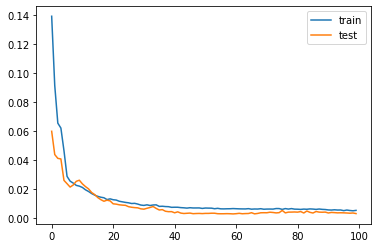

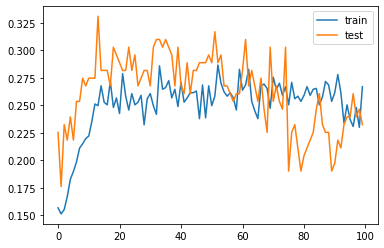

Test loss:0.26%
Test score:26.70%
Train on 1270 samples, validate on 142 samples
Epoch 1/100
1270/1270 - 0s - loss: 0.0051 - accuracy: 0.2693 - val_loss: 0.0034 - val_accuracy: 0.3099
Epoch 2/100
1270/1270 - 0s - loss: 0.0053 - accuracy: 0.2441 - val_loss: 0.0031 - val_accuracy: 0.3169
Epoch 3/100
1270/1270 - 0s - loss: 0.0048 - accuracy: 0.2646 - val_loss: 0.0033 - val_accuracy: 0.3028
Epoch 4/100
1270/1270 - 0s - loss: 0.0051 - accuracy: 0.2496 - val_loss: 0.0031 - val_accuracy: 0.2958
Epoch 5/100
1270/1270 - 0s - loss: 0.0049 - accuracy: 0.2402 - val_loss: 0.0032 - val_accuracy: 0.3169
Epoch 6/100
1270/1270 - 0s - loss: 0.0050 - accuracy: 0.2496 - val_loss: 0.0030 - val_accuracy: 0.3028
Epoch 7/100
1270/1270 - 0s - loss: 0.0052 - accuracy: 0.2425 - val_loss: 0.0030 - val_accuracy: 0.2887
Epoch 8/100
1270/1270 - 0s - loss: 0.0050 - accuracy: 0.2512 - val_loss: 0.0030 - val_accuracy: 0.3169
Epoch 9/100
1270/1270 - 0s - loss: 0.0049 - accuracy: 0.2370 - val_loss: 0.0031 - val_accuracy:

1270/1270 - 0s - loss: 0.0042 - accuracy: 0.2331 - val_loss: 0.0031 - val_accuracy: 0.2958
Epoch 80/100
1270/1270 - 0s - loss: 0.0043 - accuracy: 0.2323 - val_loss: 0.0032 - val_accuracy: 0.3099
Epoch 81/100
1270/1270 - 0s - loss: 0.0041 - accuracy: 0.2417 - val_loss: 0.0031 - val_accuracy: 0.2324
Epoch 82/100
1270/1270 - 0s - loss: 0.0043 - accuracy: 0.2252 - val_loss: 0.0031 - val_accuracy: 0.2535
Epoch 83/100
1270/1270 - 0s - loss: 0.0043 - accuracy: 0.2472 - val_loss: 0.0031 - val_accuracy: 0.2324
Epoch 84/100
1270/1270 - 0s - loss: 0.0043 - accuracy: 0.2488 - val_loss: 0.0032 - val_accuracy: 0.3239
Epoch 85/100
1270/1270 - 0s - loss: 0.0043 - accuracy: 0.2378 - val_loss: 0.0034 - val_accuracy: 0.2958
Epoch 86/100
1270/1270 - 0s - loss: 0.0044 - accuracy: 0.2378 - val_loss: 0.0031 - val_accuracy: 0.2254
Epoch 87/100
1270/1270 - 0s - loss: 0.0042 - accuracy: 0.2315 - val_loss: 0.0032 - val_accuracy: 0.3099
Epoch 88/100
1270/1270 - 0s - loss: 0.0043 - accuracy: 0.2276 - val_loss: 0.0

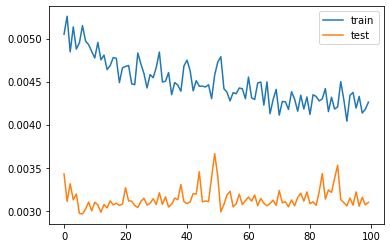

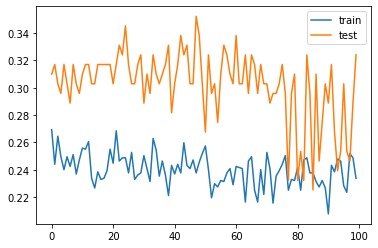

Test loss:0.19%
Test score:27.05%
Train on 1271 samples, validate on 141 samples
Epoch 1/100
1271/1271 - 0s - loss: 0.0042 - accuracy: 0.2337 - val_loss: 0.0022 - val_accuracy: 0.2270
Epoch 2/100
1271/1271 - 0s - loss: 0.0044 - accuracy: 0.2148 - val_loss: 0.0035 - val_accuracy: 0.2270
Epoch 3/100
1271/1271 - 0s - loss: 0.0043 - accuracy: 0.2219 - val_loss: 0.0031 - val_accuracy: 0.2199
Epoch 4/100
1271/1271 - 0s - loss: 0.0046 - accuracy: 0.2478 - val_loss: 0.0029 - val_accuracy: 0.2057
Epoch 5/100
1271/1271 - 0s - loss: 0.0045 - accuracy: 0.2290 - val_loss: 0.0025 - val_accuracy: 0.2411
Epoch 6/100
1271/1271 - 0s - loss: 0.0042 - accuracy: 0.2368 - val_loss: 0.0026 - val_accuracy: 0.2411
Epoch 7/100
1271/1271 - 0s - loss: 0.0044 - accuracy: 0.2195 - val_loss: 0.0025 - val_accuracy: 0.2340
Epoch 8/100
1271/1271 - 0s - loss: 0.0042 - accuracy: 0.2172 - val_loss: 0.0028 - val_accuracy: 0.2624
Epoch 9/100
1271/1271 - 0s - loss: 0.0042 - accuracy: 0.2140 - val_loss: 0.0028 - val_accuracy:

1271/1271 - 0s - loss: 0.0040 - accuracy: 0.2164 - val_loss: 0.0036 - val_accuracy: 0.2553
Epoch 80/100
1271/1271 - 0s - loss: 0.0042 - accuracy: 0.2486 - val_loss: 0.0030 - val_accuracy: 0.2695
Epoch 81/100
1271/1271 - 0s - loss: 0.0041 - accuracy: 0.2360 - val_loss: 0.0029 - val_accuracy: 0.2837
Epoch 82/100
1271/1271 - 0s - loss: 0.0040 - accuracy: 0.2360 - val_loss: 0.0034 - val_accuracy: 0.2411
Epoch 83/100
1271/1271 - 0s - loss: 0.0039 - accuracy: 0.2376 - val_loss: 0.0031 - val_accuracy: 0.2837
Epoch 84/100
1271/1271 - 0s - loss: 0.0039 - accuracy: 0.2345 - val_loss: 0.0031 - val_accuracy: 0.2482
Epoch 85/100
1271/1271 - 0s - loss: 0.0041 - accuracy: 0.2219 - val_loss: 0.0034 - val_accuracy: 0.2482
Epoch 86/100
1271/1271 - 0s - loss: 0.0040 - accuracy: 0.2439 - val_loss: 0.0028 - val_accuracy: 0.2411
Epoch 87/100
1271/1271 - 0s - loss: 0.0039 - accuracy: 0.2345 - val_loss: 0.0033 - val_accuracy: 0.2340
Epoch 88/100
1271/1271 - 0s - loss: 0.0040 - accuracy: 0.2352 - val_loss: 0.0

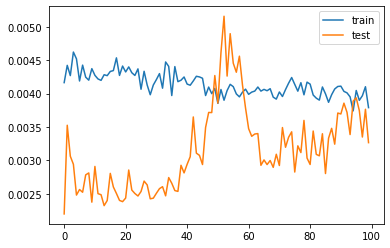

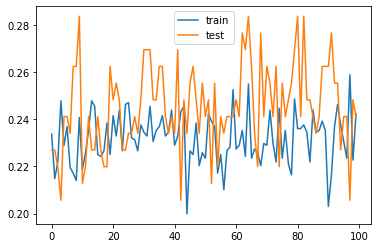

Test loss:0.19%
Test score:27.20%
Train on 1271 samples, validate on 141 samples
Epoch 1/100
1271/1271 - 0s - loss: 0.0041 - accuracy: 0.2227 - val_loss: 0.0025 - val_accuracy: 0.2624
Epoch 2/100
1271/1271 - 0s - loss: 0.0041 - accuracy: 0.2455 - val_loss: 0.0026 - val_accuracy: 0.3191
Epoch 3/100
1271/1271 - 0s - loss: 0.0040 - accuracy: 0.2258 - val_loss: 0.0025 - val_accuracy: 0.3191
Epoch 4/100
1271/1271 - 0s - loss: 0.0042 - accuracy: 0.2219 - val_loss: 0.0029 - val_accuracy: 0.3121
Epoch 5/100
1271/1271 - 0s - loss: 0.0039 - accuracy: 0.2219 - val_loss: 0.0025 - val_accuracy: 0.2766
Epoch 6/100
1271/1271 - 0s - loss: 0.0041 - accuracy: 0.2368 - val_loss: 0.0027 - val_accuracy: 0.3191
Epoch 7/100
1271/1271 - 0s - loss: 0.0040 - accuracy: 0.2101 - val_loss: 0.0024 - val_accuracy: 0.2908
Epoch 8/100
1271/1271 - 0s - loss: 0.0039 - accuracy: 0.2195 - val_loss: 0.0024 - val_accuracy: 0.2837
Epoch 9/100
1271/1271 - 0s - loss: 0.0042 - accuracy: 0.2463 - val_loss: 0.0025 - val_accuracy:

Epoch 80/100
1271/1271 - 0s - loss: 0.0038 - accuracy: 0.2368 - val_loss: 0.0030 - val_accuracy: 0.2553
Epoch 81/100
1271/1271 - 0s - loss: 0.0037 - accuracy: 0.2313 - val_loss: 0.0031 - val_accuracy: 0.2766
Epoch 82/100
1271/1271 - 0s - loss: 0.0039 - accuracy: 0.2258 - val_loss: 0.0031 - val_accuracy: 0.2411
Epoch 83/100
1271/1271 - 0s - loss: 0.0036 - accuracy: 0.2439 - val_loss: 0.0029 - val_accuracy: 0.3121
Epoch 84/100
1271/1271 - 0s - loss: 0.0037 - accuracy: 0.2250 - val_loss: 0.0031 - val_accuracy: 0.2411
Epoch 85/100
1271/1271 - 0s - loss: 0.0038 - accuracy: 0.2360 - val_loss: 0.0030 - val_accuracy: 0.2695
Epoch 86/100
1271/1271 - 0s - loss: 0.0038 - accuracy: 0.2329 - val_loss: 0.0029 - val_accuracy: 0.2695
Epoch 87/100
1271/1271 - 0s - loss: 0.0038 - accuracy: 0.2250 - val_loss: 0.0032 - val_accuracy: 0.2837
Epoch 88/100
1271/1271 - 0s - loss: 0.0039 - accuracy: 0.2463 - val_loss: 0.0030 - val_accuracy: 0.2553
Epoch 89/100
1271/1271 - 0s - loss: 0.0038 - accuracy: 0.2109 - 

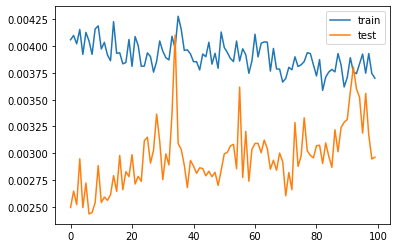

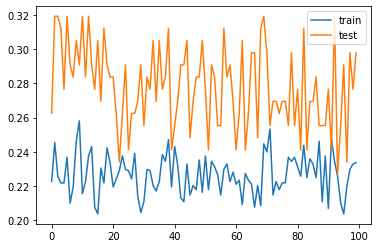

Test loss:0.18%
Test score:26.91%
Train on 1271 samples, validate on 141 samples
Epoch 1/100
1271/1271 - 0s - loss: 0.0040 - accuracy: 0.2234 - val_loss: 7.3193e-04 - val_accuracy: 0.2128
Epoch 2/100
1271/1271 - 0s - loss: 0.0041 - accuracy: 0.2352 - val_loss: 4.1895e-04 - val_accuracy: 0.1844
Epoch 3/100
1271/1271 - 0s - loss: 0.0039 - accuracy: 0.2172 - val_loss: 4.2396e-04 - val_accuracy: 0.1986
Epoch 4/100
1271/1271 - 0s - loss: 0.0040 - accuracy: 0.2305 - val_loss: 4.7563e-04 - val_accuracy: 0.2270
Epoch 5/100
1271/1271 - 0s - loss: 0.0039 - accuracy: 0.2321 - val_loss: 5.4540e-04 - val_accuracy: 0.2837
Epoch 6/100
1271/1271 - 0s - loss: 0.0040 - accuracy: 0.2384 - val_loss: 7.2521e-04 - val_accuracy: 0.2766
Epoch 7/100
1271/1271 - 0s - loss: 0.0040 - accuracy: 0.2172 - val_loss: 0.0021 - val_accuracy: 0.2624
Epoch 8/100
1271/1271 - 0s - loss: 0.0041 - accuracy: 0.2305 - val_loss: 8.5579e-04 - val_accuracy: 0.2695
Epoch 9/100
1271/1271 - 0s - loss: 0.0040 - accuracy: 0.2415 - val_

Epoch 78/100
1271/1271 - 0s - loss: 0.0038 - accuracy: 0.2329 - val_loss: 0.0018 - val_accuracy: 0.2908
Epoch 79/100
1271/1271 - 0s - loss: 0.0039 - accuracy: 0.2109 - val_loss: 0.0021 - val_accuracy: 0.2837
Epoch 80/100
1271/1271 - 0s - loss: 0.0038 - accuracy: 0.2321 - val_loss: 0.0020 - val_accuracy: 0.2482
Epoch 81/100
1271/1271 - 0s - loss: 0.0037 - accuracy: 0.2124 - val_loss: 0.0016 - val_accuracy: 0.3121
Epoch 82/100
1271/1271 - 0s - loss: 0.0036 - accuracy: 0.2116 - val_loss: 0.0014 - val_accuracy: 0.2979
Epoch 83/100
1271/1271 - 0s - loss: 0.0038 - accuracy: 0.2305 - val_loss: 0.0017 - val_accuracy: 0.3262
Epoch 84/100
1271/1271 - 0s - loss: 0.0037 - accuracy: 0.2321 - val_loss: 0.0013 - val_accuracy: 0.3050
Epoch 85/100
1271/1271 - 0s - loss: 0.0038 - accuracy: 0.2234 - val_loss: 0.0026 - val_accuracy: 0.3050
Epoch 86/100
1271/1271 - 0s - loss: 0.0039 - accuracy: 0.2054 - val_loss: 0.0020 - val_accuracy: 0.2766
Epoch 87/100
1271/1271 - 0s - loss: 0.0038 - accuracy: 0.2250 - 

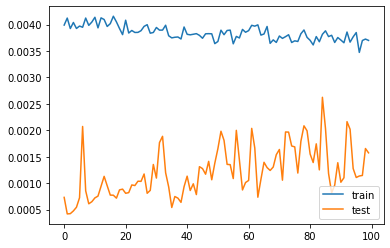

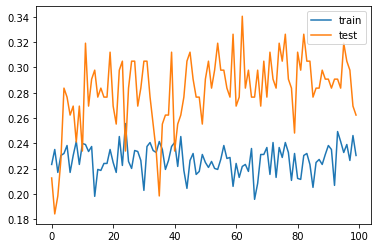

Test loss:0.17%
Test score:25.85%
Train on 1271 samples, validate on 141 samples
Epoch 1/100
1271/1271 - 0s - loss: 0.0034 - accuracy: 0.2266 - val_loss: 0.0047 - val_accuracy: 0.2199
Epoch 2/100
1271/1271 - 0s - loss: 0.0034 - accuracy: 0.2187 - val_loss: 0.0060 - val_accuracy: 0.2411
Epoch 3/100
1271/1271 - 0s - loss: 0.0036 - accuracy: 0.2360 - val_loss: 0.0045 - val_accuracy: 0.2482
Epoch 4/100
1271/1271 - 0s - loss: 0.0034 - accuracy: 0.2195 - val_loss: 0.0044 - val_accuracy: 0.2411
Epoch 5/100
1271/1271 - 0s - loss: 0.0034 - accuracy: 0.2093 - val_loss: 0.0042 - val_accuracy: 0.2482
Epoch 6/100
1271/1271 - 0s - loss: 0.0035 - accuracy: 0.2085 - val_loss: 0.0041 - val_accuracy: 0.2128
Epoch 7/100
1271/1271 - 0s - loss: 0.0032 - accuracy: 0.2368 - val_loss: 0.0048 - val_accuracy: 0.2128
Epoch 8/100
1271/1271 - 0s - loss: 0.0033 - accuracy: 0.2470 - val_loss: 0.0042 - val_accuracy: 0.2411
Epoch 9/100
1271/1271 - 0s - loss: 0.0033 - accuracy: 0.2329 - val_loss: 0.0046 - val_accuracy:

1271/1271 - 0s - loss: 0.0032 - accuracy: 0.2431 - val_loss: 0.0046 - val_accuracy: 0.1986
Epoch 80/100
1271/1271 - 0s - loss: 0.0032 - accuracy: 0.2368 - val_loss: 0.0058 - val_accuracy: 0.2199
Epoch 81/100
1271/1271 - 0s - loss: 0.0034 - accuracy: 0.2219 - val_loss: 0.0066 - val_accuracy: 0.2553
Epoch 82/100
1271/1271 - 0s - loss: 0.0033 - accuracy: 0.2250 - val_loss: 0.0052 - val_accuracy: 0.2482
Epoch 83/100
1271/1271 - 0s - loss: 0.0033 - accuracy: 0.2179 - val_loss: 0.0051 - val_accuracy: 0.2199
Epoch 84/100
1271/1271 - 0s - loss: 0.0031 - accuracy: 0.2282 - val_loss: 0.0047 - val_accuracy: 0.2908
Epoch 85/100
1271/1271 - 0s - loss: 0.0032 - accuracy: 0.2242 - val_loss: 0.0048 - val_accuracy: 0.2340
Epoch 86/100
1271/1271 - 0s - loss: 0.0032 - accuracy: 0.2234 - val_loss: 0.0061 - val_accuracy: 0.2482
Epoch 87/100
1271/1271 - 0s - loss: 0.0032 - accuracy: 0.2156 - val_loss: 0.0069 - val_accuracy: 0.2482
Epoch 88/100
1271/1271 - 0s - loss: 0.0032 - accuracy: 0.2195 - val_loss: 0.0

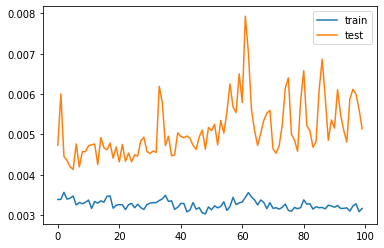

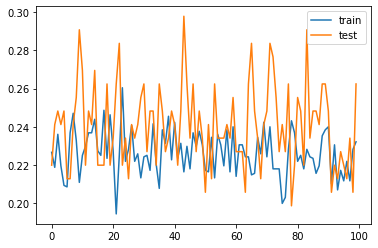

Test loss:0.16%
Test score:26.13%
Train on 1271 samples, validate on 141 samples
Epoch 1/100
1271/1271 - 0s - loss: 0.0038 - accuracy: 0.2085 - val_loss: 0.0010 - val_accuracy: 0.3121
Epoch 2/100
1271/1271 - 0s - loss: 0.0037 - accuracy: 0.2290 - val_loss: 0.0024 - val_accuracy: 0.3546
Epoch 3/100
1271/1271 - 0s - loss: 0.0038 - accuracy: 0.2101 - val_loss: 0.0027 - val_accuracy: 0.2979
Epoch 4/100
1271/1271 - 0s - loss: 0.0040 - accuracy: 0.2321 - val_loss: 0.0014 - val_accuracy: 0.3121
Epoch 5/100
1271/1271 - 0s - loss: 0.0039 - accuracy: 0.2014 - val_loss: 0.0011 - val_accuracy: 0.3546
Epoch 6/100
1271/1271 - 0s - loss: 0.0041 - accuracy: 0.2234 - val_loss: 0.0017 - val_accuracy: 0.3262
Epoch 7/100
1271/1271 - 0s - loss: 0.0039 - accuracy: 0.2172 - val_loss: 0.0015 - val_accuracy: 0.3191
Epoch 8/100
1271/1271 - 0s - loss: 0.0038 - accuracy: 0.2195 - val_loss: 0.0012 - val_accuracy: 0.3121
Epoch 9/100
1271/1271 - 0s - loss: 0.0037 - accuracy: 0.2258 - val_loss: 0.0021 - val_accuracy:

Epoch 79/100
1271/1271 - 0s - loss: 0.0034 - accuracy: 0.2439 - val_loss: 0.0028 - val_accuracy: 0.3121
Epoch 80/100
1271/1271 - 0s - loss: 0.0036 - accuracy: 0.2156 - val_loss: 0.0028 - val_accuracy: 0.3262
Epoch 81/100
1271/1271 - 0s - loss: 0.0035 - accuracy: 0.2541 - val_loss: 0.0015 - val_accuracy: 0.2553
Epoch 82/100
1271/1271 - 0s - loss: 0.0036 - accuracy: 0.2203 - val_loss: 0.0013 - val_accuracy: 0.3121
Epoch 83/100
1271/1271 - 0s - loss: 0.0035 - accuracy: 0.2384 - val_loss: 0.0020 - val_accuracy: 0.2482
Epoch 84/100
1271/1271 - 0s - loss: 0.0034 - accuracy: 0.2030 - val_loss: 0.0023 - val_accuracy: 0.2553
Epoch 85/100
1271/1271 - 0s - loss: 0.0035 - accuracy: 0.2305 - val_loss: 0.0029 - val_accuracy: 0.3262
Epoch 86/100
1271/1271 - 0s - loss: 0.0035 - accuracy: 0.2297 - val_loss: 0.0032 - val_accuracy: 0.3050
Epoch 87/100
1271/1271 - 0s - loss: 0.0034 - accuracy: 0.2069 - val_loss: 0.0024 - val_accuracy: 0.3121
Epoch 88/100
1271/1271 - 0s - loss: 0.0035 - accuracy: 0.2305 - 

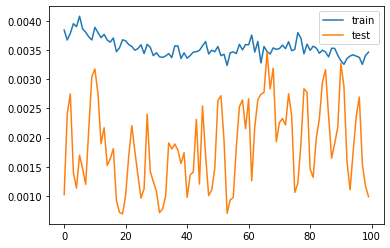

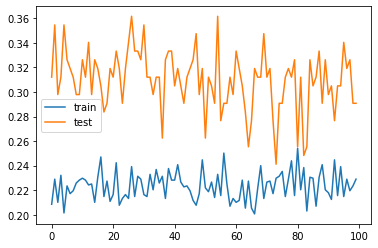

Test loss:0.15%
Test score:25.64%
Train on 1271 samples, validate on 141 samples
Epoch 1/100
1271/1271 - 0s - loss: 0.0034 - accuracy: 0.2046 - val_loss: 0.0011 - val_accuracy: 0.2837
Epoch 2/100
1271/1271 - 0s - loss: 0.0035 - accuracy: 0.2274 - val_loss: 9.1930e-04 - val_accuracy: 0.2979
Epoch 3/100
1271/1271 - 0s - loss: 0.0035 - accuracy: 0.2234 - val_loss: 0.0014 - val_accuracy: 0.3333
Epoch 4/100
1271/1271 - 0s - loss: 0.0036 - accuracy: 0.2187 - val_loss: 8.7091e-04 - val_accuracy: 0.2624
Epoch 5/100
1271/1271 - 0s - loss: 0.0037 - accuracy: 0.2266 - val_loss: 0.0021 - val_accuracy: 0.2695
Epoch 6/100
1271/1271 - 0s - loss: 0.0038 - accuracy: 0.2132 - val_loss: 0.0012 - val_accuracy: 0.2908
Epoch 7/100
1271/1271 - 0s - loss: 0.0037 - accuracy: 0.2187 - val_loss: 9.9810e-04 - val_accuracy: 0.3121
Epoch 8/100
1271/1271 - 0s - loss: 0.0035 - accuracy: 0.2132 - val_loss: 9.2277e-04 - val_accuracy: 0.2979
Epoch 9/100
1271/1271 - 0s - loss: 0.0034 - accuracy: 0.2164 - val_loss: 9.3153

Epoch 78/100
1271/1271 - 0s - loss: 0.0032 - accuracy: 0.2242 - val_loss: 0.0011 - val_accuracy: 0.2979
Epoch 79/100
1271/1271 - 0s - loss: 0.0035 - accuracy: 0.2392 - val_loss: 9.6093e-04 - val_accuracy: 0.3191
Epoch 80/100
1271/1271 - 0s - loss: 0.0034 - accuracy: 0.2242 - val_loss: 0.0012 - val_accuracy: 0.2624
Epoch 81/100
1271/1271 - 0s - loss: 0.0031 - accuracy: 0.2054 - val_loss: 0.0011 - val_accuracy: 0.2908
Epoch 82/100
1271/1271 - 0s - loss: 0.0032 - accuracy: 0.2282 - val_loss: 9.6529e-04 - val_accuracy: 0.2908
Epoch 83/100
1271/1271 - 0s - loss: 0.0032 - accuracy: 0.2368 - val_loss: 9.9717e-04 - val_accuracy: 0.2908
Epoch 84/100
1271/1271 - 0s - loss: 0.0032 - accuracy: 0.2234 - val_loss: 0.0011 - val_accuracy: 0.2766
Epoch 85/100
1271/1271 - 0s - loss: 0.0033 - accuracy: 0.2305 - val_loss: 9.7182e-04 - val_accuracy: 0.2837
Epoch 86/100
1271/1271 - 0s - loss: 0.0032 - accuracy: 0.2384 - val_loss: 9.1721e-04 - val_accuracy: 0.2766
Epoch 87/100
1271/1271 - 0s - loss: 0.0032 -

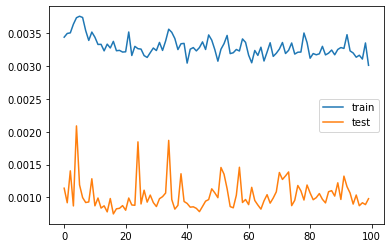

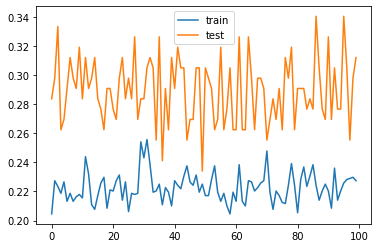

Test loss:0.10%
Test score:26.70%
Train on 1271 samples, validate on 141 samples
Epoch 1/100
1271/1271 - 0s - loss: 0.0031 - accuracy: 0.2077 - val_loss: 3.6656e-04 - val_accuracy: 0.3333
Epoch 2/100
1271/1271 - 0s - loss: 0.0033 - accuracy: 0.2132 - val_loss: 7.2051e-04 - val_accuracy: 0.2340
Epoch 3/100
1271/1271 - 0s - loss: 0.0033 - accuracy: 0.2109 - val_loss: 3.9282e-04 - val_accuracy: 0.3121
Epoch 4/100
1271/1271 - 0s - loss: 0.0033 - accuracy: 0.2352 - val_loss: 4.0614e-04 - val_accuracy: 0.2482
Epoch 5/100
1271/1271 - 0s - loss: 0.0034 - accuracy: 0.2195 - val_loss: 3.7835e-04 - val_accuracy: 0.2766
Epoch 6/100
1271/1271 - 0s - loss: 0.0031 - accuracy: 0.2360 - val_loss: 3.6543e-04 - val_accuracy: 0.2979
Epoch 7/100
1271/1271 - 0s - loss: 0.0034 - accuracy: 0.2148 - val_loss: 5.3148e-04 - val_accuracy: 0.2979
Epoch 8/100
1271/1271 - 0s - loss: 0.0032 - accuracy: 0.2376 - val_loss: 3.1589e-04 - val_accuracy: 0.2979
Epoch 9/100
1271/1271 - 0s - loss: 0.0034 - accuracy: 0.2219 - 

Epoch 77/100
1271/1271 - 0s - loss: 0.0030 - accuracy: 0.2179 - val_loss: 5.1572e-04 - val_accuracy: 0.2553
Epoch 78/100
1271/1271 - 0s - loss: 0.0032 - accuracy: 0.2242 - val_loss: 5.8991e-04 - val_accuracy: 0.1986
Epoch 79/100
1271/1271 - 0s - loss: 0.0030 - accuracy: 0.2415 - val_loss: 3.4898e-04 - val_accuracy: 0.2482
Epoch 80/100
1271/1271 - 0s - loss: 0.0031 - accuracy: 0.2297 - val_loss: 4.5815e-04 - val_accuracy: 0.2837
Epoch 81/100
1271/1271 - 0s - loss: 0.0032 - accuracy: 0.2282 - val_loss: 3.9707e-04 - val_accuracy: 0.2411
Epoch 82/100
1271/1271 - 0s - loss: 0.0029 - accuracy: 0.2392 - val_loss: 4.1783e-04 - val_accuracy: 0.2340
Epoch 83/100
1271/1271 - 0s - loss: 0.0030 - accuracy: 0.2227 - val_loss: 4.7221e-04 - val_accuracy: 0.2270
Epoch 84/100
1271/1271 - 0s - loss: 0.0030 - accuracy: 0.2109 - val_loss: 4.1837e-04 - val_accuracy: 0.3191
Epoch 85/100
1271/1271 - 0s - loss: 0.0030 - accuracy: 0.2305 - val_loss: 3.9074e-04 - val_accuracy: 0.2837
Epoch 86/100
1271/1271 - 0s 

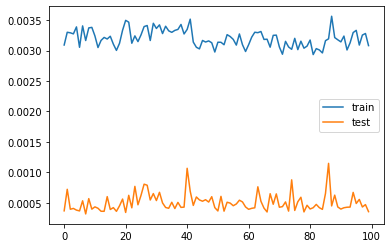

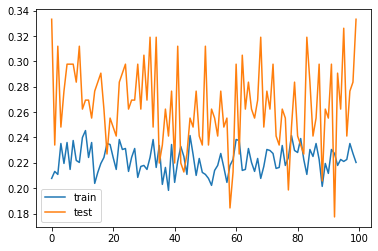

Test loss:0.11%
Test score:27.20%
Train on 1271 samples, validate on 141 samples
Epoch 1/100
1271/1271 - 0s - loss: 0.0032 - accuracy: 0.2187 - val_loss: 8.8360e-04 - val_accuracy: 0.3262
Epoch 2/100
1271/1271 - 0s - loss: 0.0030 - accuracy: 0.2187 - val_loss: 9.1564e-04 - val_accuracy: 0.2908
Epoch 3/100
1271/1271 - 0s - loss: 0.0031 - accuracy: 0.2164 - val_loss: 8.7692e-04 - val_accuracy: 0.2908
Epoch 4/100
1271/1271 - 0s - loss: 0.0032 - accuracy: 0.2116 - val_loss: 8.8311e-04 - val_accuracy: 0.2979
Epoch 5/100
1271/1271 - 0s - loss: 0.0030 - accuracy: 0.2219 - val_loss: 8.5629e-04 - val_accuracy: 0.3333
Epoch 6/100
1271/1271 - 0s - loss: 0.0029 - accuracy: 0.2242 - val_loss: 8.9189e-04 - val_accuracy: 0.2695
Epoch 7/100
1271/1271 - 0s - loss: 0.0030 - accuracy: 0.2195 - val_loss: 9.3767e-04 - val_accuracy: 0.2979
Epoch 8/100
1271/1271 - 0s - loss: 0.0031 - accuracy: 0.2258 - val_loss: 8.3420e-04 - val_accuracy: 0.3546
Epoch 9/100
1271/1271 - 0s - loss: 0.0030 - accuracy: 0.2116 - 

Epoch 79/100
1271/1271 - 0s - loss: 0.0031 - accuracy: 0.2038 - val_loss: 0.0014 - val_accuracy: 0.2979
Epoch 80/100
1271/1271 - 0s - loss: 0.0033 - accuracy: 0.2384 - val_loss: 0.0013 - val_accuracy: 0.2766
Epoch 81/100
1271/1271 - 0s - loss: 0.0032 - accuracy: 0.2172 - val_loss: 0.0014 - val_accuracy: 0.2553
Epoch 82/100
1271/1271 - 0s - loss: 0.0031 - accuracy: 0.2242 - val_loss: 0.0013 - val_accuracy: 0.2908
Epoch 83/100
1271/1271 - 0s - loss: 0.0033 - accuracy: 0.2250 - val_loss: 0.0015 - val_accuracy: 0.3050
Epoch 84/100
1271/1271 - 0s - loss: 0.0035 - accuracy: 0.2179 - val_loss: 0.0015 - val_accuracy: 0.2624
Epoch 85/100
1271/1271 - 0s - loss: 0.0030 - accuracy: 0.1959 - val_loss: 0.0015 - val_accuracy: 0.2695
Epoch 86/100
1271/1271 - 0s - loss: 0.0030 - accuracy: 0.2345 - val_loss: 0.0011 - val_accuracy: 0.2766
Epoch 87/100
1271/1271 - 0s - loss: 0.0031 - accuracy: 0.2384 - val_loss: 0.0013 - val_accuracy: 0.2624
Epoch 88/100
1271/1271 - 0s - loss: 0.0030 - accuracy: 0.2101 - 

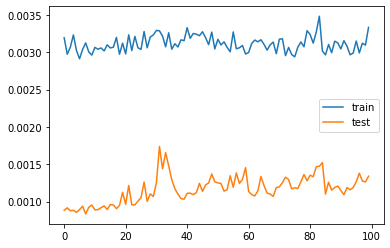

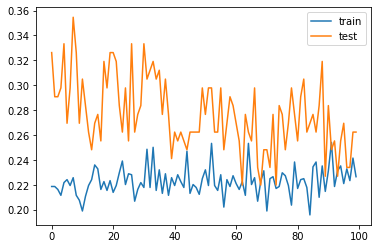

Test loss:0.13%
Test score:25.99%


In [33]:
# design LSTM Model
model = Sequential()
model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(n_predict, kernel_initializer='lecun_uniform', activation='relu'))
optimizer = Adam(lr=0.001, decay=1e-6)
model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

# store score & loss for each fold
score_arr = []
loss_arr = []

# num split for cross-validation
num_splits = 10

# k-fold cross validation
kf = KFold(n_splits=num_splits)
kf.get_n_splits(X)
KFold(n_splits=num_splits, random_state=None, shuffle=False)

# begin cross-validation procedure
for train_index, test_index in kf.split(X):
    
    # split x and y into train and test
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # fit Model
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=2, shuffle=False)
    
    # plot loss history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    # plot loss history
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()
        
    # Score model
    X = X.reshape((X.shape[0], n_input, n_features))
    loss, score = model.evaluate(X, y, verbose=0)
    print('Test loss:%.2f%%' % (loss * 100))
    print('Test score:%.2f%%' % (score * 100))
    
    loss_arr.append(loss)
    score_arr.append(score)

## Prepare Prediction

In [34]:
test_X = test_X.reshape((test_X.shape[0], n_input, n_features))

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_input*n_features))

print(yhat.shape)
print(test_X[:, -(n_features-1):].shape)

# initialize empty pred_arr and actual_arr
pred_arr = np.empty((test_X.shape[0], 1))
actual_arr = np.empty((test_X.shape[0], 1))

#empty = np.empty((test_X.shape[0], 9))

# invert scaling for forecast
for i in range(0, yhat.shape[1]):
    yhat_col = yhat[:, i].reshape(len(yhat[:, i]), 1)    
    inv_yhat = np.concatenate((yhat_col, test[:, -(test.shape[1]-1):]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    inv_yhat = inv_yhat.reshape(len(inv_yhat), 1)
    pred_arr = np.append(pred_arr, inv_yhat, axis=1)    
pred_arr = pred_arr[:,1:]

# invert scaling for actual
for i in range(0, test_y.shape[1]):
    test_y_col = test_y[:, i].reshape(len(test_y[:, i]), 1)
    inv_y = np.concatenate((test_y_col, test[:, -(test.shape[1]-1):]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    inv_y = inv_y.reshape(len(inv_y), 1)
    actual_arr = np.append(actual_arr, inv_y, axis=1)
actual_arr = actual_arr[:,1:]

(353, 7)
(353, 13)


## Evaluate Model

In [35]:
# summarize k-fold results
for i in range(len(score_arr)):
    print('K-Fold {}: Loss:{:.4f}, Score:{:.3f}'.format(i+1, loss_arr[i], score_arr[i] * 100))

K-Fold 1: Loss:0.0026, Score:26.700
K-Fold 2: Loss:0.0019, Score:27.054
K-Fold 3: Loss:0.0019, Score:27.195
K-Fold 4: Loss:0.0018, Score:26.912
K-Fold 5: Loss:0.0017, Score:25.850
K-Fold 6: Loss:0.0016, Score:26.133
K-Fold 7: Loss:0.0015, Score:25.637
K-Fold 8: Loss:0.0010, Score:26.700
K-Fold 9: Loss:0.0011, Score:27.195
K-Fold 10: Loss:0.0013, Score:25.992


In [98]:
actual = pd.DataFrame()
actual.insert(0, 'company_id', test_X[:, 1])
actual.insert(1, 'volume_tests', inv_y)
actual

,company_id,volume_tests
0,1.0,37.0
1,0.0,20759.0
2,1.0,32.0
3,0.0,35561.0
4,1.0,7907.0
...,...,...
348,1.0,4667.0
349,0.0,21660.0
350,1.0,1.0
351,0.0,22244.0


In [68]:
prediction = pd.DataFrame()
prediction.insert(0, 'company_id', test_X[:, 1])
prediction.insert(1, 'volume_tests', inv_yhat)
prediction

,company_id,volume_tests
0,1.0,0.000000
1,0.0,19349.186347
2,1.0,0.000000
3,0.0,30817.878636
4,1.0,7360.066476
...,...,...
348,1.0,5582.347778
349,0.0,18389.896305
350,1.0,0.000000
351,0.0,17523.272629


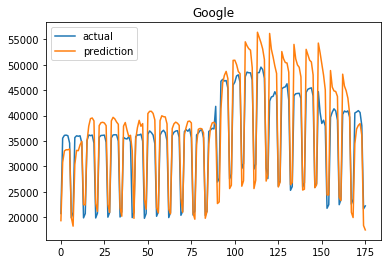

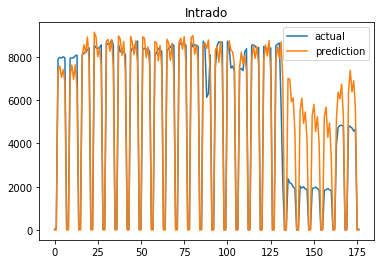

In [102]:
# plot actual vs prediction
plt.plot(list(actual.loc[actual['company_id'] == 0]['volume_tests']), label='actual')
plt.plot(list(prediction[prediction['company_id'] == 0]['volume_tests']), label='prediction')
plt.legend()
plt.title("Google")
plt.show()

plt.plot(list(actual.loc[actual['company_id'] > 0]['volume_tests']), label='actual')
plt.plot(list(prediction[prediction['company_id'] > 0]['volume_tests']), label='prediction')
plt.legend()
plt.title("Intrado")
plt.show()

In [39]:
test_X = test_X.reshape((test_X.shape[0], n_input, n_features))

inv_yhat = pred_arr[:, 0].reshape(len(pred_arr), 1)
inv_y = actual_arr[:, 0].reshape(len(actual_arr), 1)

print(inv_yhat.shape)
print(inv_y.shape)

# print predicted vs expected
num_days = y.shape[0]
accuracy_scores = []
for i in range(len(inv_y[:num_days])):
    if inv_y[i] > inv_yhat[i]:
        score = inv_yhat[i] / inv_y[i] * 100
        if score > 0:
            accuracy_scores.append(score)
    else:
        score = inv_y[i] / inv_yhat[i] * 100
        if score > 0:
            accuracy_scores.append(score)
    print('Day=%d, Expected=%.2f, Predicted=%.2f, Accuracy=%.2f%%' % (i+1, inv_y[i], inv_yhat[i], score ))
print("Avg. Accuracy %.2f%% (+/- %.2f%%)" % (np.mean(accuracy_scores), np.std(accuracy_scores)))

(353, 1)
(353, 1)
Day=1, Expected=37.00, Predicted=0.00, Accuracy=0.00%
Day=2, Expected=20759.00, Predicted=19349.19, Accuracy=93.21%
Day=3, Expected=32.00, Predicted=0.00, Accuracy=0.00%
Day=4, Expected=35561.00, Predicted=30817.88, Accuracy=86.66%
Day=5, Expected=7907.00, Predicted=7360.07, Accuracy=93.08%
Day=6, Expected=36124.00, Predicted=33062.24, Accuracy=91.52%
Day=7, Expected=7984.00, Predicted=7579.15, Accuracy=94.93%
Day=8, Expected=36174.00, Predicted=33298.56, Accuracy=92.05%
Day=9, Expected=7959.00, Predicted=7058.46, Accuracy=88.69%
Day=10, Expected=36055.00, Predicted=33283.90, Accuracy=92.31%
Day=11, Expected=8009.00, Predicted=7419.10, Accuracy=92.63%
Day=12, Expected=34601.00, Predicted=33428.64, Accuracy=96.61%
Day=13, Expected=7962.00, Predicted=6822.05, Accuracy=85.68%
Day=14, Expected=19900.00, Predicted=19948.62, Accuracy=99.76%
Day=15, Expected=37.00, Predicted=0.00, Accuracy=0.00%
Day=16, Expected=20997.00, Predicted=18265.15, Accuracy=86.99%
Day=17, Expected=

Day=201, Expected=8733.00, Predicted=8093.85, Accuracy=92.68%
Day=202, Expected=46606.00, Predicted=50903.94, Accuracy=91.56%
Day=203, Expected=8458.00, Predicted=8758.85, Accuracy=96.57%
Day=204, Expected=47815.00, Predicted=50039.30, Accuracy=95.55%
Day=205, Expected=7488.00, Predicted=8304.15, Accuracy=90.17%
Day=206, Expected=48032.00, Predicted=48684.67, Accuracy=98.66%
Day=207, Expected=7585.00, Predicted=8246.62, Accuracy=91.98%
Day=208, Expected=46543.00, Predicted=48262.37, Accuracy=96.44%
Day=209, Expected=7342.00, Predicted=7611.24, Accuracy=96.46%
Day=210, Expected=29589.00, Predicted=26122.12, Accuracy=88.28%
Day=211, Expected=4.00, Predicted=0.00, Accuracy=0.00%
Day=212, Expected=30561.00, Predicted=27191.36, Accuracy=88.97%
Day=213, Expected=28.00, Predicted=0.00, Accuracy=0.00%
Day=214, Expected=47664.00, Predicted=54525.30, Accuracy=87.42%
Day=215, Expected=7436.00, Predicted=7522.45, Accuracy=98.85%
Day=216, Expected=48567.00, Predicted=53740.86, Accuracy=90.37%
Day=2

/home/shanebowen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


In [40]:
print("\n######  RMSE #######\n")

rmse_arr = []
# calculate RMSE
for i in range(0, actual_arr.shape[1]):
    rmse = sqrt(mean_squared_error(actual_arr[:, i], pred_arr[:, i]))
    rmse_arr.append(rmse)
    print('t+{} RMSE: {:.3f}'.format(i+1, rmse))
print('Avg. RMSE: {:.3f}'.format(np.mean(rmse_arr)))
    
print("\n######  MAE  #######\n")
    
mae_arr = []
# calculate MAE
for i in range(0, actual_arr.shape[1]):
    mae = mean_absolute_error(actual_arr[:, i], pred_arr[:, i])
    mae_arr.append(mae)
    print('t+{} MAE: {:.3f}'.format(i+1, mae))
print('Avg. MAE: {:.3f}'.format(np.mean(mae_arr)))


######  RMSE #######

t+1 RMSE: 3085.283
t+2 RMSE: 3882.282
t+3 RMSE: 3734.895
t+4 RMSE: 4266.803
t+5 RMSE: 4360.896
t+6 RMSE: 4181.057
t+7 RMSE: 3722.441
Avg. RMSE: 3890.522

######  MAE  #######

t+1 MAE: 2011.992
t+2 MAE: 2438.162
t+3 MAE: 2385.561
t+4 MAE: 2718.031
t+5 MAE: 2767.702
t+6 MAE: 2722.881
t+7 MAE: 2461.139
Avg. MAE: 2500.781
